# VAE (not nan with 100 epochs and latent space 200)

In [1]:
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras import Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import moviepy.editor as mp
import numpy as np
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

2023-03-13 21:24:14.748184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 21:24:15.118979: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 21:24:15.197351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 21:24:15.197375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2023-03-13 21:24:20.825450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jacksibley/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-13 21:24:20.825908: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 21:24:20.825946: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Jacks): /proc/driver/nvidia/version does not exist


In [4]:
ds = image_dataset_from_directory('zelle', label_mode=None, image_size=(448, 448), batch_size=16)

Found 253 files belonging to 1 classes.


2023-03-13 21:24:20.868966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
ds = ds.map(lambda x: x/255)
# ds = ds.map(lambda x: (x, x))

In [6]:
imgs = ds.as_numpy_iterator().__next__()

In [7]:
imgs.shape

(16, 448, 448, 3)

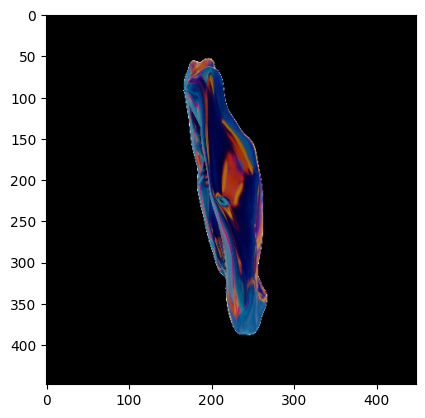

In [8]:
plt.imshow(imgs[0])


In [9]:
#X_train = ds.map(lambda x : x/255).batch(16).prefetch(tf.data.AUTOTUNE)

In [10]:
from keras.layers import Lambda

In [11]:
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Layer

In [12]:
import tensorflow as tf
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
latent_dim = 200


input_image = Input(shape=(448, 448, 3))
    
x = Conv2D(32, (3, 3), padding='same', activation="relu")(input_image)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
encoder_output = Dense(latent_dim, activation="relu")(x)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(input_image, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 224, 224, 32  0           ['conv2d[0][0]']                 
                                )                                                           

In [14]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))  
x = Dense(7*7*64, activation='tanh')(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)


    
decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
decoder = Model(inputs=latent_inputs, outputs=decoder_output, name="decoder")
decoder.summary()
    

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              630336    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      1475

In [15]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [16]:
ds

<MapDataset element_spec=TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None)>

In [17]:
#next_images = ds.as_numpy_iterator().__next__()

In [18]:
#vae.decoder(vae.encoder(next_images[0].reshape(-1,448,448,3))[0])

In [19]:
class CallbackSaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.model.save_weights(f'/home/jupyter/model_{epoch}')

save_model = CallbackSaveModel()

In [20]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
#vae.load_weights('model_10')
#vae.fit(ds, epochs=10, callbacks=[save_model])

In [21]:
vae.save_weights('save_model_100epochs_200latdim')

In [63]:
vae.load_weights('model_vae_2500') #load_weights



In [23]:
encoded_images = vae.encoder(imgs[10:12].reshape(-1,448,448,3))
decoded_images = vae.decoder(encoded_images[0])

In [24]:
encoded_images[1].shape

TensorShape([2, 200])

In [25]:
enc_imgs = vae.encoder.predict(imgs[10:11])

1/1 [==============================] - 0s 179ms/step


In [26]:
len(enc_imgs)

3

In [27]:
encoded_images_2 = vae.encoder(imgs[10:12])

In [28]:
imgs[10:12].shape

(2, 448, 448, 3)

In [29]:
from tensorflow import keras
#model = keras.models.load_model('model_vae_2500.data-00000-of-00001')

In [30]:
#vae.fit

In [31]:
#prediction = vae.predict(ds, verbose=0)

# Original Image

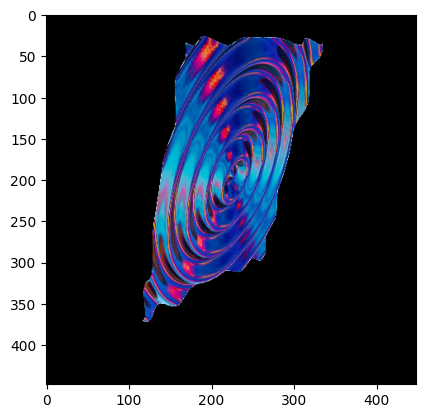

In [32]:
plt.imshow(imgs[14])

# VAE reconstructed image

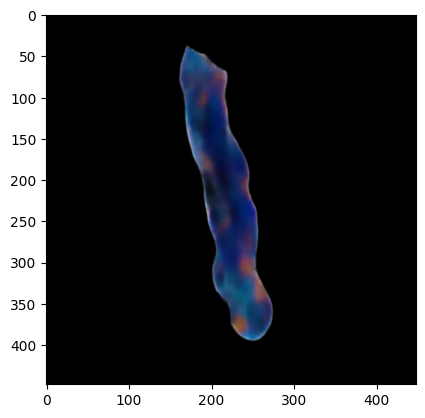

In [33]:
encoded_image = vae.encoder(imgs[5].reshape(-1,448,448,3))
decoded_image = vae.decoder(encoded_image[0])
plt.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))

In [34]:
# for i in range(3):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
#     encoded_image = vae.encoder(imgs[i].reshape(-1,448,448,3))
#     decoded_image = vae.decoder(encoded_image[0])
#     ax2.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))
#     ax1.imshow(imgs[i])

# Audio and video

In [35]:
import librosa
y, sr = librosa.load('Piano.wav')

# calculate desired hop length based on 24 fps
fps = 24
hop_length = int(sr / fps)

# calculate optimal n_fft length based on hop length
n_fft = 2 ** (hop_length - 1).bit_length()

# ENVELOPES WITH HOP LENGTH DETERMINED BY FPS
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length = hop_length, n_fft=n_fft)

onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units='time')
len(onset_frames)

N_STEPS = len(onset_env)

frame_duration = 1/fps
audio_movement = []

times = librosa.times_like(onset_env, sr=24)

# Stuff

In [56]:
onset_env_norm = librosa.util.normalize(onset_env)


302

In [37]:
start_lat_vec, end_lat_vec = encoded_images[0][0], encoded_images[0][1]
start_lat_vec.shape, end_lat_vec.shape

(TensorShape([200]), TensorShape([200]))

In [38]:
len(librosa.times_like(onset_env, sr=sr))

302

In [62]:
step_vec = (end_lat_vec - start_lat_vec ) / N_STEPS
interpolation_images = []

# OG interpolation
# for i in range(0, N_STEPS):
#     interpolation_images.append(start_lat_vec + (i * (step_vec *(onset_env_norm[i] + 1.9))))

interp_array = np.array(interpolation_images)
interp_array.shape

(302,)


AxisError: axis -1 is out of bounds for array of dimension 0

In [40]:
audio_time = librosa.get_duration(y=y)
# int_1_ms = audio_time*1000
# audio_N_STEPS_ms = 1/frames_per_second * 1000
# step_time = int_1_ms/audio_N_STEPS_ms
# interpolation_images_and_audio = []
# for n in range(0, N_STEPS):
#     audio_movement.append(start_lat_vec + (i * step_vec))
# interp_array = np.array(interpolation_images)


In [41]:
#inter_images_encoded = vae.encoder(interp_array).reshape(-1,448,448,3)
inter_images_decoded = vae.decoder(interp_array)

inter_images = (inter_images_decoded.numpy() * 255).astype('uint8')


In [43]:
for i in range(inter_images.shape[0]):
    im = Image.fromarray(inter_images[i])
    im.save(f'./images/image_{i}.jpg')

# Load the audio file
audio_clip = mp.AudioFileClip('Piano.wav')

# Define the frame folder where the images are stored
frame_folder = './images'

# Get the list of image paths
im_paths = [os.path.join(frame_folder, f'image_{i}.jpg') for i in range(N_STEPS)]

# Load the images as frames
frames = [mp.ImageClip(image_path).set_duration(frame_duration) # equal to 24fps
          for image_path in im_paths]

# Combine the frames into a video
video_clip = mp.concatenate_videoclips(frames, method='chain')  # experiment with different method values

# Overlay the audio on the video
final_clip = video_clip.set_audio(audio_clip)

# Write the final video to file
final_clip.write_videofile("Aoutput_video.mp4", fps=24) #

Moviepy - Building video Aoutput_video.mp4.
MoviePy - Writing audio in Aoutput_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video Aoutput_video.mp4



Moviepy - Done !
Moviepy - video ready Aoutput_video.mp4


# Functions

In [44]:
from typing import Tuple
import numpy as np
import librosa
import os
from PIL import Image
import moviepy.editor as mp

def generate_latents(path_to_audio: str, vae, fps: int = 24, frame_folder: str = './images') -> None:
    """
    Generates a video with frames interpolated between two latent vectors of a VAE, based on the onset
    strength of an audio file.

    Args:
        path_to_audio (str): The path to the audio file
        vae: The VAE model used for image generation
        fps (int): The frames per second for the output video (default 24)
        frame_folder (str): The folder path to save the frames (default './images')
    
    Returns:
        None
    """
    # load audio and sample rate
    y, sr = librosa.load(path_to_audio)

    # calculate desired hop length based on 24 fps
    hop_length = int(sr / fps)

    # calculate optimal n_fft length based on hop length
    n_fft = 2 ** (hop_length - 1).bit_length()

    # calculate onset envelopes and normalize 
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)
    onset_env_norm = librosa.util.normalize(onset_env)

    # get number of steps (frames)
    n_steps = len(onset_env)

    # generate encoded images for interpolation
    encoded_images = vae.encoder(imgs[10:12].reshape(-1, 448, 448, 3))
    start_lat_vec, end_lat_vec = encoded_images[0][0], encoded_images[0][1]
    step_vec = (end_lat_vec - start_lat_vec) / n_steps

    # interpolate between start and end latent vectors based on onset strength
    interpolation_images = []
    for i in range(n_steps):
        interpolation_images.append(start_lat_vec + (i * (step_vec * (onset_env_norm[i] + 1))))
    interpolation_array = np.array(interpolation_images)

    # decode interpolated images
    inter_images_decoded = vae.decoder(interpolation_array)
    inter_images = (inter_images_decoded.numpy() * 255).astype('uint8')

    # save images to frame folder
    for i in range(inter_images.shape[0]):
        im = Image.fromarray(inter_images[i])
        im.save(os.path.join(frame_folder, f'image_{i}.jpg'))

In [45]:
# import os
# from typing import List
# import numpy as np
# import moviepy.editor as mp
# from PIL import Image


def create_video_with_audio(inter_images: np.ndarray, audio_file_path: str, output_video_path: str,
                            frame_folder: str = './images', fps: int = 24, frame_duration: float = 1.0) -> None:
    """
    Creates a video clip by concatenating a series of images with an audio clip.
    
    Parameters:
    -----------
    inter_images: numpy.ndarray
        Array of images to be used as frames in the video clip.
    audio_file_path: str
        Path to the audio file to be overlaid on the video clip.
    output_video_path: str
        Path to save the output video file.
    frame_folder: str, optional (default='./images')
        Folder where the image frames are stored.
    fps: int, optional (default=24)
        Frames per second to use when creating the video clip.
    frame_duration: float, optional (default=1.0)
        Duration of each frame in seconds.
    
    Returns:
    --------
    None
    """
    
    # Validate inputs
    if not isinstance(inter_images, np.ndarray):
        raise TypeError("Input argument 'inter_images' must be a numpy.ndarray.")
    
    if not isinstance(audio_file_path, str):
        raise TypeError("Input argument 'audio_file_path' must be a string.")
    
    if not isinstance(output_video_path, str):
        raise TypeError("Input argument 'output_video_path' must be a string.")
    
    if not isinstance(frame_folder, str):
        raise TypeError("Input argument 'frame_folder' must be a string.")
    
    if not isinstance(fps, int):
        raise TypeError("Input argument 'fps' must be an integer.")
    
    if not isinstance(frame_duration, (int, float)):
        raise TypeError("Input argument 'frame_duration' must be a numeric value.")
    
    if not os.path.exists(frame_folder):
        raise ValueError(f"Frame folder '{frame_folder}' does not exist.")
    
    if not os.path.exists(audio_file_path):
        raise ValueError(f"Audio file '{audio_file_path}' does not exist.")
    
    # Create frames from the input images
    im_paths = [os.path.join(frame_folder, f'image_{i}.jpg') for i in range(inter_images.shape[0])]
    frames = [mp.ImageClip(image_path).set_duration(frame_duration) for image_path in im_paths]
    
    # Load the audio file
    audio_clip = mp.AudioFileClip(audio_file_path)
    
    # Combine the frames into a video clip
    video_clip = mp.concatenate_videoclips(frames, method='chain')
    
    # Overlay the audio on the video clip
    final_clip = video_clip.set_audio(audio_clip)
    
    # Write the final video clip to file
    final_clip.write_videofile(output_video_path, fps=fps)

In [46]:
# Both functions in one 


# from typing import Tuple
# import numpy as np
# import librosa
# import os
# from PIL import Image
# import moviepy.editor as mp

def generate_video(path_to_audio: str, vae, fps: int = 24, frame_folder: str = './images') -> None:
    """
    Generates a video with frames interpolated between two latent vectors of a VAE, based on the onset
    strength of an audio file.

    Args:
        path_to_audio (str): The path to the audio file
        vae: The VAE model used for image generation
        fps (int): The frames per second for the output video (default 24)
        frame_folder (str): The folder path to save the frames (default './images')
    
    Returns:
        None
    """
    # load audio and sample rate
    y, sr = librosa.load(path_to_audio)

    # calculate desired hop length based on 24 fps
    hop_length = int(sr / fps)

    # calculate optimal n_fft length based on hop length
    n_fft = 2 ** (hop_length - 1).bit_length()

    # calculate onset envelopes and normalize 
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)
    onset_env_norm = librosa.util.normalize(onset_env)

    # get number of steps (frames)
    n_steps = len(onset_env)

    # generate encoded images for interpolation
    encoded_images = vae.encoder(imgs[10:12].reshape(-1, 448, 448, 3))
    start_lat_vec, end_lat_vec = encoded_images[0][0], encoded_images[0][1]
    step_vec = (end_lat_vec - start_lat_vec) / n_steps

    # interpolate between start and end latent vectors based on onset strength
    interpolation_images = []
    for i in range(n_steps):
        interpolation_images.append(start_lat_vec + (i * (step_vec * (onset_env_norm[i] + 1))))
    interpolation_array = np.array(interpolation_images)

    # decode interpolated images
    inter_images_decoded = vae.decoder(interpolation_array)
    inter_images = (inter_images_decoded.numpy() * 255).astype('uint8')

    # save images to frame folder
    for i in range(inter_images.shape[0]):
        im = Image.fromarray(inter_images[i])
        im.save(os.path.join(frame_folder, f'image_{i}.jpg'))

    # load the audio clip
    audio_clip = mp.AudioFileClip(path_to_audio)

    # get the list of image paths
    im_paths = [os.path.join(frame_folder, f'image_{i}.jpg') for i in range(n_steps)]

    # load the images as frames
    frames = [mp.ImageClip(image_path).set_duration(1/fps) for image_path in im_paths]

    # combine the frames into a video
    video_clip = mp.concatenate_videoclips(frames, method='chain')

    # overlay the audio on the video
    final_clip = video_clip.set_audio(audio_clip)

    # write the final video to file
    final_clip.write_videofile("output_video.mp4", fps=fps, codec='libx264')

In [ ]:
path_to_audio = "Drums.wav"

generate_video(path_to_audio=path_to_audio, fps=24, )

create_vi



